In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy import ndimage, misc
import cv2
from skimage.morphology import skeletonize
from fil_finder import FilFinder2D
import astropy.units as u
from sklearn import linear_model
from sklearn import model_selection 
import gc
import tifffile

In [473]:
# import initial image and metrics data
%cd C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\matches 
    
#img =cv2.imread('random_7_final_crop_masks.tif') #segmented and eroded image
#metrics=pd.read_csv('exported_metrics_random_7.csv')
df_3=np.load('match_3.npy')
df_4=np.load('match_4.npy')
df_7=np.load('match_7.npy')
df_8=np.load('match_8.npy')
#plt.imshow(img)

C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\matches


In [474]:
df=np.concatenate((df_3,df_4,df_7,df_8),axis=0)
df=df_4
df

array([[1.50000000e+03, 1.00000000e+02, 7.95000000e+02, 2.33000000e+02,
        8.40000000e+01, 3.59146132e-02],
       [3.30000000e+03, 1.00000000e+02, 1.66200000e+03, 2.01000000e+02,
        6.70000000e+01, 2.19377020e-02],
       [3.70000000e+03, 1.00000000e+02, 1.97500000e+03, 1.08000000e+02,
        1.80000000e+02, 1.06599512e-01],
       [1.00000000e+02, 5.00000000e+02, 7.60000000e+01, 5.64000000e+02,
        6.10000000e+01, 2.19621919e-02],
       [6.30000000e+03, 5.00000000e+02, 3.23800000e+03, 1.85000000e+02,
        5.60000000e+01, 3.16956248e-02],
       [1.10000000e+03, 7.00000000e+02, 6.00000000e+02, 6.37000000e+02,
        7.90000000e+01, 4.22677500e-03],
       [1.30000000e+03, 7.00000000e+02, 7.29000000e+02, 5.93000000e+02,
        5.10000000e+01, 1.21110094e-02],
       [1.70000000e+03, 7.00000000e+02, 9.36000000e+02, 5.76000000e+02,
        2.20000000e+01, 5.87077802e-03],
       [3.30000000e+03, 7.00000000e+02, 1.73500000e+03, 4.33000000e+02,
        1.62000000e+02, 

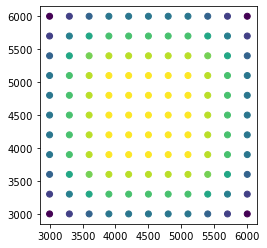

In [390]:
n=0
test=np.zeros([31*31,2])
for ii in range(31):
    for jj in range(31):
        
        test[n,0]=ii*300
        test[n,1]=jj*300
        n=n+1
obj=np.zeros(np.shape(test)[0])
for kk in range(np.shape(test)[0]):
    if test[kk,0]>2800 and test[kk,1]>2800 and test[kk,0]<6100 and test[kk,1]<6100:
        obj[kk]=1
    else:
        obj[kk]=0
        
#plt.scatter(test[:,0],test[:,1],c=obj[:])

window_radius=[ 1000]

cx=test[:,0]
cy=test[:,1]
# Find Canny edges


number_mat=np.zeros([np.shape(cx)[0],np.size(window_radius)])
density=np.zeros([np.shape(cx)[0],np.size(window_radius)])
grad=np.zeros([np.shape(cx)[0],np.size(window_radius)])
lap=np.zeros([np.shape(cx)[0],np.size(window_radius)])
for ii in range(np.shape(cx)[0]):
    if obj[ii]==1:
        repe=np.repeat([[cx[ii],cy[ii]]],np.shape(cx)[0], axis=0)
        vec=np.transpose([cx,cy])-repe
        dist=np.sqrt((cx[:]-repe[:,0])**2+(cy[:]-repe[:,1])**2)
        x_dist=(cx[:]-repe[:,0])
        y_dist=(cy[:]-repe[:,1])
        dist[dist==0]=np.nan
        #print(dist)
        for jj in range(np.size(window_radius)):
            ids=np.argwhere(dist<window_radius[jj])
            
       
            number=np.count_nonzero(obj[ids]!=0) #include self?
            
            number_mat[ii,jj]=number
            density[ii,jj]=number/(np.pi*window_radius[jj]**2)*obj[ii]
        
            r=dist[ids]
            
        
            f_x=(-x_dist[ids]/r**(3/2))*obj[ids]-1
            f_y=(-y_dist[ids]/r**(3/2))*obj[ids]-1
            f=(1/r**2)*obj[ids]-1
            grad_x=np.sum(np.multiply(f_x,vec[ids,0])/r)
            grad_y=np.sum(np.multiply(f_y,vec[ids,1])/r)
            grad[ii,jj]=np.sqrt(grad_x**2+grad_y**2)*obj[ii]
            
            lap[ii,jj]=np.sum(f)*obj[ii]
        
matrix_test=np.concatenate((density, grad,lap), axis=1)
for ii in range(np.size(matrix_test,1)):
    if np.std(matrix_test[obj!=0,ii]) >0:
        matrix_test[obj!=0,ii]=(matrix_test[obj!=0,ii]-np.mean(matrix_test[obj!=0,ii]))/np.std(matrix_test[obj!=0,ii])
        
plt.scatter(test[obj!=0,0],test[obj!=0,1],c=matrix_test[obj!=0,1])
plt.axis('square')
plt.show()

In [480]:
# calculate density, del and del^2 of regions given a window size
window_radius=[200, 500, 800, 1000, 1200, 1500, 2000]
y=df[:,5]
cx1=df[:,0]
cy1=df[:,1]

# Find Canny edges
edged = cv2.Canny(img, 30, 200)
n=0
test=np.zeros([81*81,2])
for ii in range(81):
    for jj in range(81):
        
        test[n,0]=ii*200-2900
        test[n,1]=jj*200-2900
        n=n+1
obj=np.zeros(np.shape(test)[0])
dip=np.zeros(np.shape(test)[0])
for kk in range(np.shape(cx1)[0]):
    ind_x=np.where(test[:,0]==cx1[kk])
    ind_y=np.where(test[:,1]==cy1[kk])
    ind=np.intersect1d(ind_x,ind_y)
    obj[ind]=1
    dip[ind]=y[kk]
#contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cx=test[:,0]
cy=test[:,1]
number_mat=np.zeros([np.shape(cx)[0],np.size(window_radius)])
density=np.zeros([np.shape(cx)[0],np.size(window_radius)])
grad=np.zeros([np.shape(cx)[0],np.size(window_radius)])
lap=np.zeros([np.shape(cx)[0],np.size(window_radius)])
for ii in range(np.shape(cx)[0]):
    if obj[ii]==1:
        repe=np.repeat([[cx[ii],cy[ii]]],np.shape(cx)[0], axis=0)
        vec=np.transpose([cx,cy])-repe
        dist=np.sqrt((cx[:]-repe[:,0])**2+(cy[:]-repe[:,1])**2)
        x_dist=(cx[:]-repe[:,0])
        y_dist=(cy[:]-repe[:,1])
        dist[dist==0]=np.nan
        #print(dist)
        for jj in range(np.size(window_radius)):
            ids=np.argwhere(dist<window_radius[jj])
            
       
            number=np.count_nonzero(obj[ids]!=0) #include self?
            
            number_mat[ii,jj]=number
            density[ii,jj]=number/(np.pi*window_radius[jj]**2)*obj[ii]
        
            r=dist[ids]
            
        
            f_x=(-x_dist[ids]/r**(3/2))*obj[ids]-1
            f_y=(-y_dist[ids]/r**(3/2))*obj[ids]-1
            f=(1/r**2)*obj[ids]-1
            grad_x=np.sum(np.multiply(f,vec[ids,0])/r)
            grad_y=np.sum(np.multiply(f,vec[ids,1])/r)
            grad[ii,jj]=np.sqrt(grad_x**2+grad_y**2)*obj[ii]
            
            lap[ii,jj]=np.sum(f)*obj[ii]
        
matrix_t=np.concatenate((density,grad), axis=1)
for ii in range(np.size(matrix_t,1)):
    if np.std(matrix_t[obj!=0,ii]) >0:
        matrix_t[obj!=0,ii]=(matrix_t[obj!=0,ii]-np.mean(matrix_t[obj!=0,ii]))/np.std(matrix_t[obj!=0,ii])
        #normalize density, grad nad lap (-avg)/std
'''
ok=0       
while ok==0:    
    alpha=np.random.rand(1)
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(density, y)
    if np.size(np.where(clf.coef_!=0))==3:
        ok=1
'''

model = linear_model.Lasso()
# define model evaluation method
cv = model_selection.RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)
# define search
search = model_selection.GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search

f_matrix=matrix_t[obj!=0,:]
#matrix_t=density

dip_norm=(dip[obj!=0]-np.mean(dip[obj!=0]))/np.std(dip[obj!=0])
results = search.fit(f_matrix, dip_norm)
print(results.best_params_)   


#normalize matrix_t


{'alpha': 0.17}


In [483]:
clf = linear_model.Lasso(alpha=0.25)
clf.fit(f_matrix, dip_norm)
print(clf.coef_)

[0.         0.07667841 0.         0.         0.06300791 0.02204786
 0.         0.         0.13114072 0.         0.         0.
 0.         0.03189955]


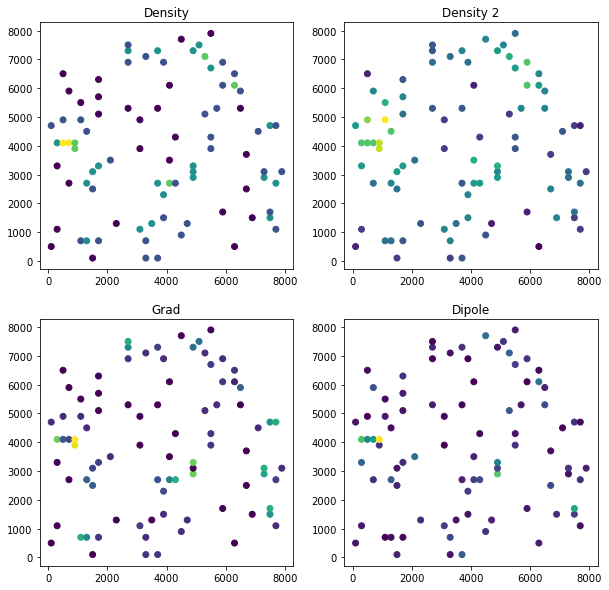

In [484]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
axs[0,0].scatter(test[obj!=0,0],test[obj!=0,1],c=f_matrix[:,1])
axs[0,0].set_title('Density')
plt.gca().invert_yaxis()
axs[0,1].scatter(test[obj!=0,0],test[obj!=0,1],c=f_matrix[:,4])
axs[0,1].set_title('Density 2')
plt.gca().invert_yaxis()
axs[1,0].scatter(test[obj!=0,0],test[obj!=0,1],c=f_matrix[:,8])
axs[1,0].set_title('Grad')
plt.gca().invert_yaxis()
axs[1,1].scatter(test[obj!=0,0],test[obj!=0,1],c=dip_norm)
axs[1,1].set_title('Dipole')
plt.gca().invert_yaxis()

C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\data


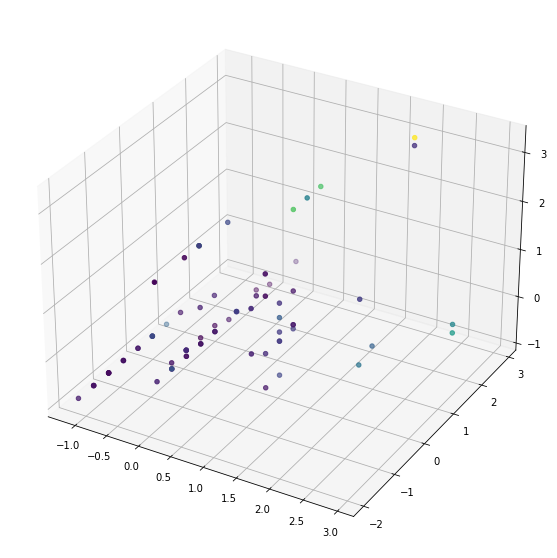

In [463]:
%cd C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\data
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')
color=y
color[color<0.125]=0
color[color>0.125]=1
ax.scatter(f_matrix[:,1],f_matrix[:,4],f_matrix[:,8],c=dip_norm[:])
#ax.scatter(matrix_test[:,1],matrix_test[:,3],matrix_test[:,11],c='r')
plt.draw()



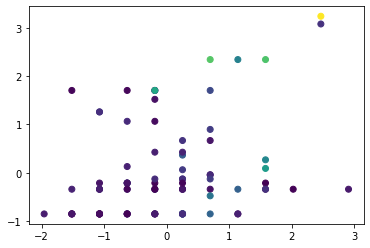

In [464]:
plt.scatter(f_matrix[:,4],f_matrix[:,8],c=dip_norm[:])
#plt.scatter(matrix_test[:,1],matrix_test[:,3],c='r')

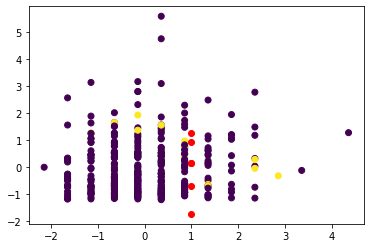

In [179]:
plt.scatter(matrix_t[:,1],matrix_t[:,11],c=color[:])
plt.scatter(matrix_test[:,1],matrix_test[:,11],c='r')

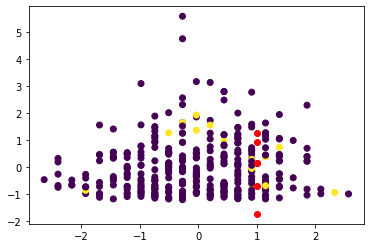

In [180]:
plt.scatter(matrix_t[:,3],matrix_t[:,11],c=color[:])
plt.scatter(matrix_test[:,3],matrix_test[:,11],c='r')

(array([180.,  95.,  32.,  22.,  11.,   8.,   2.,   7.,   2.,   2.,   2.,
          1.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.74611778, -0.3205591 ,  0.10499957,  0.53055825,  0.95611692,
         1.3816756 ,  1.80723428,  2.23279295,  2.65835163,  3.0839103 ,
         3.50946898,  3.93502765,  4.36058633,  4.786145  ,  5.21170368,
         5.63726235,  6.06282103,  6.4883797 ,  6.91393838,  7.33949705,
         7.76505573]),
 <BarContainer object of 20 artists>)

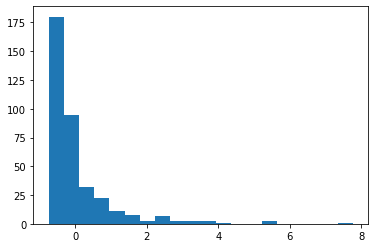

In [166]:
plt.hist(y_norm,20)

In [450]:
alpha=np.arange(0, 1, 0.001)
chi_tot=np.zeros(np.size(alpha,0))
for ii in range(np.size(alpha,0)):
    clf = linear_model.Lasso(alpha=alpha[ii])
    clf.fit(f_matrix, dip_norm)
    a=f_matrix*clf.coef_
    chi=np.zeros(np.size(a,0))
    for jj in range(np.size(a,0)):
        chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
        
    chi_tot[ii]=np.sum(chi)    


<ipython-input-450-052b3e5a05a0>:5: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  clf.fit(f_matrix, dip_norm)
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.322653760787873, tolerance: 0.008800000000000004
  model = cd_fast.enet_coordinate_descent(
C:\Users\heito\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.359286841610597, tolerance: 0.008800000000000004
  model = cd_fa

<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encountered in double_scalars
  chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encountered in double_scalars
  chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encountered in double_scalars
  chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encountered in double_scalars
  chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encounter

<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encountered in double_scalars
  chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encountered in double_scalars
  chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encountered in double_scalars
  chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encountered in double_scalars
  chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encounter

<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encountered in double_scalars
  chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encountered in double_scalars
  chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encountered in double_scalars
  chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encountered in double_scalars
  chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encounter

<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encountered in double_scalars
  chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encountered in double_scalars
  chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encountered in double_scalars
  chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encountered in double_scalars
  chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encounter

<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encountered in double_scalars
  chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encountered in double_scalars
  chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encountered in double_scalars
  chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encountered in double_scalars
  chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encounter

<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encountered in double_scalars
  chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encountered in double_scalars
  chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encountered in double_scalars
  chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encountered in double_scalars
  chi[jj]=(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_))-dip_norm[jj])**2/(np.sum(a[jj,:])-alpha[ii]*np.sum(np.abs(clf.coef_)))
<ipython-input-450-052b3e5a05a0>:9: RuntimeWarning: divide by zero encounter

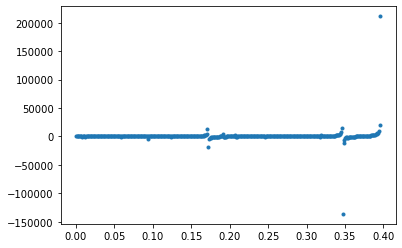

In [451]:
plt.plot(alpha,chi_tot,'.')

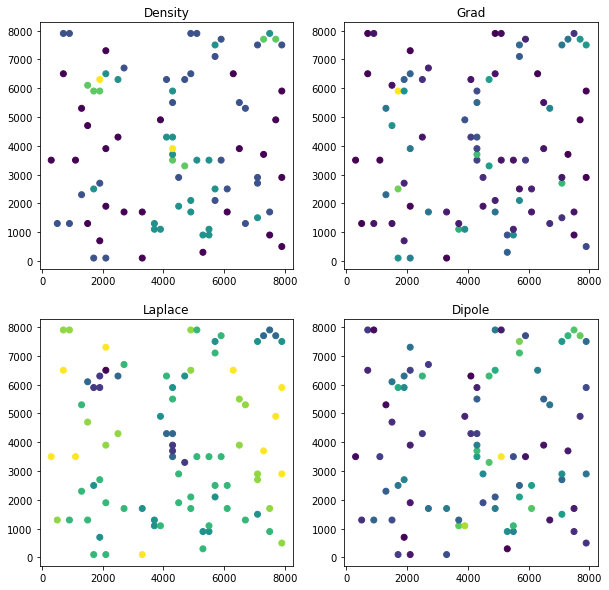

In [148]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
axs[0,0].scatter(cx,cy,c=density[:,1])
axs[0,0].set_title('Density')
plt.gca().invert_yaxis()
axs[0,1].scatter(cx,cy,c=grad[:,2])
axs[0,1].set_title('Grad')
plt.gca().invert_yaxis()
axs[1,0].scatter(cx,cy,c=lap[:,2])
axs[1,0].set_title('Laplace')
plt.gca().invert_yaxis()
axs[1,1].scatter(cx,cy,c=y)
axs[1,1].set_title('Dipole')
plt.gca().invert_yaxis()

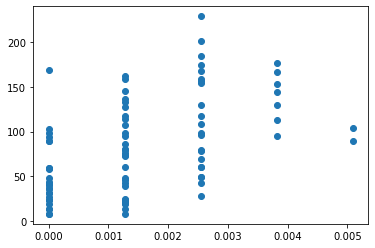

In [149]:
plt.scatter(density[:,1],y)

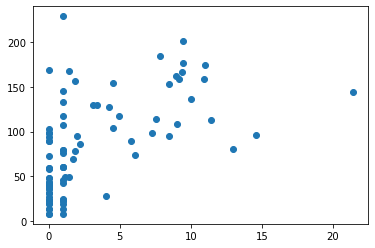

In [150]:
plt.scatter(grad[:,1],y)

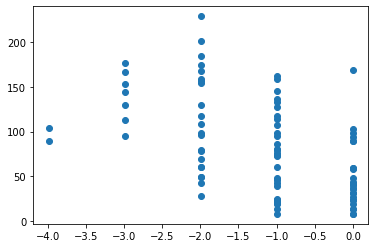

In [151]:
plt.scatter(lap[:,1],y)

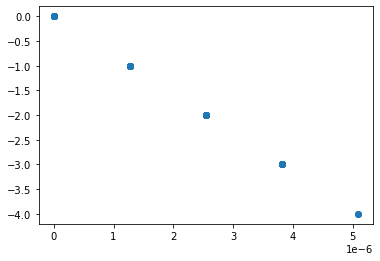

In [26]:
plt.scatter(density[:,1],lap[:,1])

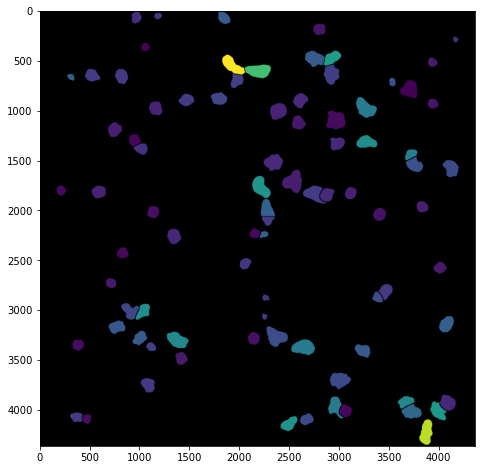

In [112]:
a=tifffile.imread('final_random_3_roi_AR.tif')
plt.figure(figsize=[8,8])
plt.imshow(a)


In [ ]:
# visualize dipole moment

im_color=np.zeros( (img.shape[0],img.shape[1]) )
 
im_color[im_color==0]=np.nan
for ii in range(np.shape(dipole_list)[0]):
    
    if true_org[ii]==1:
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image
        filled_array = cv2.fillPoly(im_zer, pts =[contours[ii]], color=(255))
        
        obj = np.argwhere(filled_array == 255)
        im_color[obj[:,0],obj[:,1]]=dipole_list[ii]
plt.figure(figsize=(10,10))

cmap = plt.cm.get_cmap("jet")
cmap.set_bad(color = 'k', alpha = 1)
img = plt.imshow(im_color, cmap=cmap)

plt.colorbar(img)


<ipython-input-27-4c20c39fdb58>:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("PiYG"))
  cmap.set_bad(color = 'k', alpha = 1)


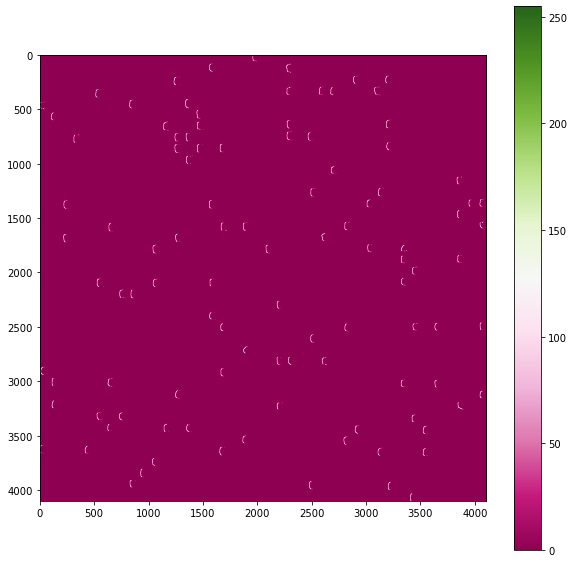

In [27]:
img =cv2.imread('random_7_init_crop_masks.tif')
np.array(img)
img.astype(float)
img_sobel=ndimage.sobel(np.array(img[:,:,0]))
img_sobel.astype(float)
#img_sobel[img_sobel==0]=np.nan
plt.figure(figsize=(10,10))
#plt.imshow(img_sobel)
cmap = plt.cm.get_cmap("PiYG")
cmap.set_bad(color = 'k', alpha = 1)
im = plt.imshow(img_sobel, cmap=cmap)

plt.colorbar(im)

In [22]:
a=np.random.randint(2,size=[5,5])
ndimage.sobel(a)


ValueError: cannot convert float NaN to integer

In [26]:
np.unique(img)

array([  0, 255], dtype=uint8)